## IF APPROACH - Rolling Window

In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("rolling_window").config("hive.metastore.uris", "thrift://amok:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session
spark.sql("USE 2023_11_02")

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-03-19 16:14:18,989 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-03-19 16:14:20,060 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2024-03-19 16:14:20,060 WARN util.Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
2024-03-19 16:14:

DataFrame[]

In [2]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as F

from pyspark.sql.functions import when
from datetime import datetime, timedelta


In [3]:
from pyspark.sql.functions import when
from datetime import datetime, timedelta

import os

curr_dir = os.getcwd()
main_dir = os.path.dirname(curr_dir)
print(main_dir)


/home/ztewari/Stock-Implosion-Prediction-FYP


## Extract Yearly Time Series

In [4]:
from CreateDataset import get_tabular_dataset, get_feature_col_names, get_not_null_cols
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv
from sklearn.impute import SimpleImputer



def get_df(fn, all_feats=False, imploded_only=False, prediction=False):
    df = get_tabular_dataset(fn, all_feats=all_feats, imploded_only=imploded_only, prediction=prediction, null_thresh=0.25) # this returns dataset of yearly time series with 1 if implosion occurred during that year
    
    df =df.toPandas()

    return df

df = get_df(f'{main_dir}/data/imploded_stocks_price2.csv', all_feats =True, prediction=False, imploded_only=False)


/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-03-19 16:14:54,239 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


{'ff_accr_exp': 0.24735519759341887, 'ff_assets_com_eq': 0.09066693555841253, 'ff_assets_eq': 0.0136462561025822, 'ff_assets_gr': 0.07086978076919845, 'ff_assets_oth_tot': 0.054038838051543185, 'ff_assets_per_emp': 0.15823438957372254, 'ff_bnfit_loss_rsrv_tcap': 0.9792701269673213, 'ff_bps_gr': 0.11114472257934407, 'ff_capex_5ygr': 0.32089709008713774, 'ff_capex_assets': 0.027603418286319292, 'ff_capex_fix_assets': 0.27038745620005544, 'ff_capex_ps_cf': 0.05854277479475997, 'ff_cash_curr_assets': 0.2473383918593024, 'ff_cash_div_cf': 0.02515818397237137, 'ff_cash_div_covg_ratio': 0.5837723831371264, 'ff_cash_roce': 0.1392355071550413, 'ff_cash_secs_deps': 0.9007957515104154, 'ff_cf_ps_gr': 0.17077146722461703, 'ff_cf_sales': 0.08607897014461334, 'ff_claims_net_prem': 0.9887653667431328, 'ff_cogs_sales': 0.24284285798314384, 'ff_com_eq_deps': 0.89766988496475, 'ff_com_eq_gr': 0.09803624996848925, 'ff_com_eq_tcap': 0.03679615484803415, 'ff_debt_com_eq': 0.09238112043829355, 'ff_debt_entr

/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

## Feature Selection

### Dropping Highly Correlated Features

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def correlation_matrix(df):
    # df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr().abs()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.savefig('corr_matrix_tab.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    corr_dict = {}
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                if corr_mat.columns[i] not in corr_dict.keys():
                    corr_dict[corr_mat.columns[i]] = [corr_mat.columns[j]]
                else:
                    corr_dict[corr_mat.columns[i]].append(corr_mat.columns[j])
                    
    for k,v in corr_dict.items():
        if len(corr_dict[k]) >= 1:
            for col in corr_dict[k]:
                if col in df.columns:
                    df=df.drop(col,axis=1)
    
                

    print(df.columns)
    return df

    
                
df=correlation_matrix(df)

Converted to Pandas
Variable pairs with absolute correlation above 0.7:
ff_accr_exp - ff_assets_gr: 0.9975865266715185
ff_accr_exp - ff_assets_oth_tot: 0.729311910524509
ff_accr_exp - ff_com_eq_gr: 0.9976046538006054
ff_accr_exp - ff_debt_lt_cf: 0.9968778689416204
ff_accr_exp - ff_debt_st_x_curr_port: 0.993187093062854
ff_accr_exp - ff_inc_tax_curr: 0.9933243313505883
ff_accr_exp - ff_inc_tax_dfd: 0.9718826392642748
ff_accr_exp - ff_int_exp_oth: 0.9978539450443064
ff_accr_exp - ff_invest_cap: 0.998714461738628
ff_accr_exp - ff_invest_lt: 0.9131100569878685
ff_accr_exp - ff_net_inc_basic_aft_xord: 0.9943689001320789
ff_accr_exp - ff_net_inc_basic_beft_xord: 0.9944708086260619
ff_accr_exp - ff_net_inc_bef_xord_gr: 0.9976628495096779
ff_accr_exp - ff_oper_inc_aft_unusual: 0.9791940158313203
ff_accr_exp - ff_oper_inc_gr: 0.9976224866688951
ff_accr_exp - ff_sales_gr: 0.9975907933389684
ff_accr_exp - ff_sales_ps_gr: 0.9976116797244476
ff_accr_exp - ff_sga_oth: 0.9991456869168318
ff_accr_exp 

### Imputation (Required before Boruta)

In [6]:
df.columns

Index(['fsym_id', 'date', 'ff_accr_exp', 'ff_assets_com_eq',
       'ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets',
       'ff_cash_curr_assets', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr',
       'ff_cf_sales', 'ff_com_eq_tcap', 'ff_debt_entrpr_val',
       'ff_dfd_tax_assets_lt', 'ff_dil_adj', 'ff_div_yld', 'ff_earn_yld',
       'ff_ebit_oper_roa', 'ff_eff_int_rate', 'ff_emp_gr',
       'ff_entrpr_val_sales', 'ff_for_assets_pct', 'ff_for_sales_pct',
       'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund', 'ff_intang_oth',
       'ff_invest_st_tot', 'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_mkt_val_gr',
       'ff_mkt_val_public', 'ff_net_inc_per_emp', 'ff_net_mgn_gr',
       'ff_non_oper_exp', 'ff_oper_cf_fix_chrg', 'ff_oper_inc_tcap',
       'ff_oper_ps_net_cf', 'ff_receiv_turn', 'ff_reinvest_rate', 'ff_roic',
       'ff_shs_float', 'ff_tcap_assets', 'ff_xord', 'ff_std_debt',
       'ff_tang_assets_debt', 'ff_bk_oper_inc_oth', 'ff_commiss_inc_net',
       'ff_cf_roic', 'ff_liab

In [7]:

feats = df.columns[2:-1]
df[feats] = df.groupby('fsym_id')[feats].transform(lambda x : x.fillna(method='ffill'))
df[feats] = df.groupby('fsym_id')[feats].transform(lambda x: x.fillna(x.median()))


/opt/jupyterhub/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/jupyterhub/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/jupyterhub/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [8]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
# df[feats] = df.groupby(['year'])[feats].transform(lambda x: x.fillna(x.mean()))

In [9]:
df=df.drop('year', axis=1)

In [10]:
feats = df.columns[2:-1]
print(len(feats))

52


In [11]:
df=df.sort_values(by=['fsym_id', 'date'])
df.head()

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_cash_curr_assets,ff_cash_div_cf,ff_cash_roce,...,ff_std_debt,ff_tang_assets_debt,ff_bk_oper_inc_oth,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,ff_compr_inc,GDP,Unemployment_Rate,label
0,B00FG1-R,2012-12-31,4.682,1.248053,10.576109,56.030954,78.273974,36.091819,0.000000,-32.48987,...,0.000000,129.518779,0.000000,0.000000,20.792882,0.0,NaN,0.006181,7.9,0
1,B00FG1-R,2013-12-31,0.499,1.016917,10.576109,56.273777,38.851847,36.091819,0.000000,-32.48987,...,0.000000,129.518779,0.000000,0.000000,-32.489870,0.0,NaN,0.014049,6.7,0
2,B00FG1-R,2014-12-31,0.499,1.016917,10.576109,-492.849757,11.984993,54.292833,3321.316445,-32.48987,...,0.000000,77.245294,-0.294125,0.294125,3.610653,0.0,NaN,0.006058,5.6,0
3,B00FG1-R,2015-12-31,0.499,1.016917,10.576109,-48.051855,0.483800,43.340449,186.785493,-32.48987,...,0.000000,70.526570,-1.071870,1.071870,19.546902,0.0,NaN,0.001821,5.0,0
4,B00FG1-R,2016-12-31,0.499,1.016917,10.576109,85.114102,2.179701,70.407743,238.208140,-32.48987,...,6.938208,130.866314,-0.710952,0.710952,21.835781,0.0,NaN,0.010414,4.7,0


'label' here needs to be altered for Approach 1 (Imploding Stock Prediction) - our target variable should be 1 if an implosion occurs after the split_date

In [12]:
def convert_to_prediction(df):
    df_temp = spark.createDataFrame(df)
    ws = Window.partitionBy('fsym_id').orderBy(F.col('date').desc())
    df_temp = df_temp.withColumn('label', F.lag(F.col('label')).over(ws))
    df_temp= df_temp.filter(F.col('label').isNotNull())
    return df_temp.toPandas()

df = convert_to_prediction(df)

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-03-19 16:19:40,528 WARN scheduler.TaskSetManager: Stage 20 contains a task of very large size (4409 KiB). The maximum recommended task size is 1000 KiB.
/opt/spark/python/pyspark/sql/pandas/conversion.py:178: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [13]:
df.head()

,fsym_id,date,ff_accr_exp,ff_assets_com_eq,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_cash_curr_assets,ff_cash_div_cf,ff_cash_roce,...,ff_std_debt,ff_tang_assets_debt,ff_bk_oper_inc_oth,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,ff_compr_inc,GDP,Unemployment_Rate,label
0,BHZYXG-R,2021-12-31,25.329,1.175993,2.135942,9.333701,0.092962,90.489671,0.0,12.831848,...,18.688339,4639.422610,0.000000,0.000000,13.108295,10.055,33.152,0.034648,3.9,0
1,BHZYXG-R,2020-12-31,23.225,1.176916,1.826904,7.653797,0.336485,89.894047,0.0,10.982966,...,15.550169,3760.077861,0.000000,0.000000,11.658896,11.497,23.337,0.017409,6.7,0
2,BHZYXG-R,2019-12-31,19.539,1.177160,1.703338,46.218731,0.210647,88.138173,0.0,12.477873,...,14.703465,3155.122586,0.000000,0.000000,13.149844,12.455,115.553,0.009593,3.6,0
3,BHZYXG-R,2018-12-31,16.412,1.205895,1.230111,79.509394,7.637973,86.069026,0.0,18.571861,...,100.000000,25096.531682,-0.045552,0.045552,14.742053,0.000,25.208,0.005728,3.9,0
4,BHZYXG-R,2017-12-31,38.969,1.563511,0.752473,-2.043736,0.810028,84.431610,0.0,-1.489816,...,100.000000,25096.531682,-0.003600,0.003600,-1.509609,0.000,-15.567,0.017494,4.1,0


In [14]:
print(len(df[df['label']==1])) #227 implosions occur after 2018

626


In [15]:
df.isnull().sum()

fsym_id                     0
date                        0
ff_accr_exp             16087
ff_assets_com_eq          396
ff_assets_per_emp        4563
ff_bps_gr                 173
ff_capex_assets           761
ff_cash_curr_assets     24015
ff_cash_div_cf            796
ff_cash_roce             1316
ff_cf_ps_gr              2466
ff_cf_sales              3461
ff_com_eq_tcap             59
ff_debt_entrpr_val       1209
ff_dfd_tax_assets_lt        0
ff_dil_adj                 94
ff_div_yld               1383
ff_earn_yld              1225
ff_ebit_oper_roa        13773
ff_eff_int_rate          3313
ff_emp_gr                5874
ff_entrpr_val_sales      4388
ff_for_assets_pct        7357
ff_for_sales_pct         5415
ff_gross_cf_debt         2182
ff_inc_adj                  0
ff_inc_sund                 0
ff_intang_oth            3369
ff_invest_st_tot        11333
ff_ltd_tcap                59
ff_min_int_tcap            68
ff_mkt_val_gr            2705
ff_mkt_val_public        4764
ff_net_inc

In [16]:
df.columns

Index(['fsym_id', 'date', 'ff_accr_exp', 'ff_assets_com_eq',
       'ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets',
       'ff_cash_curr_assets', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr',
       'ff_cf_sales', 'ff_com_eq_tcap', 'ff_debt_entrpr_val',
       'ff_dfd_tax_assets_lt', 'ff_dil_adj', 'ff_div_yld', 'ff_earn_yld',
       'ff_ebit_oper_roa', 'ff_eff_int_rate', 'ff_emp_gr',
       'ff_entrpr_val_sales', 'ff_for_assets_pct', 'ff_for_sales_pct',
       'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund', 'ff_intang_oth',
       'ff_invest_st_tot', 'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_mkt_val_gr',
       'ff_mkt_val_public', 'ff_net_inc_per_emp', 'ff_net_mgn_gr',
       'ff_non_oper_exp', 'ff_oper_cf_fix_chrg', 'ff_oper_inc_tcap',
       'ff_oper_ps_net_cf', 'ff_receiv_turn', 'ff_reinvest_rate', 'ff_roic',
       'ff_shs_float', 'ff_tcap_assets', 'ff_xord', 'ff_std_debt',
       'ff_tang_assets_debt', 'ff_bk_oper_inc_oth', 'ff_commiss_inc_net',
       'ff_cf_roic', 'ff_liab

In [17]:
len(df.columns)

55

### Boruta

In [18]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from collections import Counter


def boruta_fs(train_df, model_name):
    feats = train_df.columns[2:-1]
    train_df['date'] = pd.to_datetime(train_df['date'])
    train_df['year'] = train_df['date'].dt.year
    train_df[feats] = train_df.groupby(['year'])[feats].transform(lambda x: x.fillna(x.mean()))
    train_df=train_df.drop('year', axis=1)
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        counter = Counter(y_train)
        estimate = counter[0] / counter[1]
        print('Estimate: %.3f' % estimate)
        model = xgb.XGBClassifier(scale_pos_weight=estimate)
        
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=0, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 10:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'xgb')
# gbt_feats = boruta_fs(df, 'gbt')

Estimate: 164.564
Number of features:  52
Feature: ff_accr_exp, Rank: 23, Keep: False
Feature: ff_assets_com_eq, Rank: 22, Keep: False
Feature: ff_assets_per_emp, Rank: 4, Keep: False
Feature: ff_bps_gr, Rank: 9, Keep: False
Feature: ff_capex_assets, Rank: 3, Keep: False
Feature: ff_cash_curr_assets, Rank: 1, Keep: True
Feature: ff_cash_div_cf, Rank: 1, Keep: True
Feature: ff_cash_roce, Rank: 33, Keep: False
Feature: ff_cf_ps_gr, Rank: 1, Keep: True
Feature: ff_cf_sales, Rank: 32, Keep: False
Feature: ff_com_eq_tcap, Rank: 20, Keep: False
Feature: ff_debt_entrpr_val, Rank: 24, Keep: False
Feature: ff_dfd_tax_assets_lt, Rank: 1, Keep: True
Feature: ff_dil_adj, Rank: 37, Keep: False
Feature: ff_div_yld, Rank: 1, Keep: True
Feature: ff_earn_yld, Rank: 1, Keep: True
Feature: ff_ebit_oper_roa, Rank: 11, Keep: False
Feature: ff_eff_int_rate, Rank: 17, Keep: False
Feature: ff_emp_gr, Rank: 1, Keep: True
Feature: ff_entrpr_val_sales, Rank: 8, Keep: False
Feature: ff_for_assets_pct, Rank: 13, K

In [19]:
df = df[rf_feats + ['fsym_id', 'date', 'label']]

In [20]:
# from sklearn.feature_selection import VarianceThreshold

# # Instantiate the VarianceThreshold selector
# selector = VarianceThreshold(2)

# # Fit the selector on the training data
# selector.fit(train_df[feats])

# # Get the indices of the selected features
# selected_indices = selector.get_support(indices=True)

# selected_column_names = train_df[feats].columns[selected_indices]
# print(len(selected_column_names))

In [21]:
len(df.columns)

28

In [22]:
df[df['fsym_id'] == 'FL275K-R'].head(10)

,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_cash_curr_assets,ff_cash_div_cf,ff_cf_ps_gr,ff_dfd_tax_assets_lt,ff_div_yld,ff_earn_yld,ff_emp_gr,...,ff_xord,ff_std_debt,ff_bk_oper_inc_oth,ff_cf_roic,ff_liabs_lease,GDP,Unemployment_Rate,fsym_id,date,label
76,124.027857,-80.033522,4.878973,69.078888,-3.339702,-176.783197,0.0,1.004130,-418.51400,0.000000,...,0.0,10.276906,0.0,-3.250068,351.070,0.017409,6.7,FL275K-R,2020-12-31,1
77,237.937000,-0.129610,1.957901,65.144135,18.650227,-47.550046,0.0,0.941915,10.29580,16.666667,...,0.0,13.129146,0.0,2.330664,334.146,0.009593,3.6,FL275K-R,2019-12-31,0
78,283.971000,-1.311792,1.351899,80.256602,8.745115,262.344939,0.0,1.446650,-3.19693,0.000000,...,0.0,16.674250,0.0,4.527186,69.229,0.005728,3.9,FL275K-R,2018-12-31,0
79,273.901667,-3.594035,13.206260,83.017382,6.170517,43.389674,0.0,0.270270,-11.21620,100.000000,...,0.0,6.727019,0.0,1.260335,17.747,0.017494,4.1,FL275K-R,2017-12-31,0
80,515.719000,-61.002692,26.390793,88.096640,0.000000,43.389674,0.0,0.000000,-43.96040,-25.000000,...,0.0,2.326256,0.0,-3.623490,0.000,0.010414,4.7,FL275K-R,2016-12-31,0
81,371.359000,-59.210317,58.970565,51.014691,0.000000,62.614265,0.0,0.000000,-241.25400,33.333333,...,0.0,20.638983,0.0,-2.640037,0.000,0.001821,5.0,FL275K-R,2015-12-31,0
82,441.401667,-19.592220,49.199709,75.178867,0.000000,-2081.825198,0.0,0.000000,-43.14720,200.000000,...,0.0,3.079076,0.0,-4.180933,0.000,0.006058,5.6,FL275K-R,2014-12-31,0
83,1105.684000,-27.414065,33.616476,99.991689,0.000000,-2.080186,0.0,0.000000,-0.49751,25.000000,...,0.0,11.703026,0.0,-0.694900,0.000,0.014049,6.7,FL275K-R,2013-12-31,0


In [23]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(df.drop(['fsym_id', 'label', 'date'], axis=1))
mask = selector.get_support()
remaining_feats = df.drop(['fsym_id', 'label', 'date'], axis=1).columns[mask]
print(remaining_feats)
df = df[remaining_feats.tolist() + ['fsym_id', 'label', 'date']]

Index(['ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets',
       'ff_cash_curr_assets', 'ff_cash_div_cf', 'ff_cf_ps_gr',
       'ff_dfd_tax_assets_lt', 'ff_div_yld', 'ff_earn_yld', 'ff_emp_gr',
       'ff_entrpr_val_sales', 'ff_inc_sund', 'ff_mkt_val_gr',
       'ff_net_inc_per_emp', 'ff_oper_inc_tcap', 'ff_oper_ps_net_cf',
       'ff_roic', 'ff_shs_float', 'ff_xord', 'ff_std_debt',
       'ff_bk_oper_inc_oth', 'ff_cf_roic', 'ff_liabs_lease',
       'Unemployment_Rate'],
      dtype='object')


In [24]:
# df = df.set_index('date')
# df=df.sort_index()

### Creating the windows

In [25]:
def count_groups(df):
    num_dict = {}
    for fsym_id, group in df.groupby('fsym_id'):
        if len(group) not in num_dict.keys():
            num_dict[len(group)] = 1
        else:
            num_dict[len(group)]+=1
    print(num_dict)
    
count_groups(df)

{9: 337, 5: 658, 22: 1596, 16: 171, 18: 153, 6: 599, 4: 684, 2: 757, 23: 303, 7: 496, 1: 1067, 3: 729, 14: 254, 11: 314, 8: 338, 19: 139, 10: 351, 15: 235, 17: 156, 12: 289, 21: 151, 20: 165, 13: 246}


In [26]:
def filter_short_series(df):
    return df.groupby('fsym_id').filter(lambda x: len(x) >= 10)

filtered_df = filter_short_series(df)
print(len(filtered_df))

80046


In [27]:
df = df.set_index('date')
df=df.sort_index()

In [28]:
df.head()

,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_cash_curr_assets,ff_cash_div_cf,ff_cf_ps_gr,ff_dfd_tax_assets_lt,ff_div_yld,ff_earn_yld,ff_emp_gr,...,ff_roic,ff_shs_float,ff_xord,ff_std_debt,ff_bk_oper_inc_oth,ff_cf_roic,ff_liabs_lease,Unemployment_Rate,fsym_id,label
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,0.043518,245.158369,12.846137,64.172272,0.000000,337.163506,0.000,0.000000,5.29966,7.563358,...,43.618204,177.301723,0.000,25.831284,0.000,63.946423,0.00,3.9,D1LJ47-R,0
2000-01-31,0.043074,26.102563,6.959987,48.572847,6.455421,20.905413,0.000,0.842105,9.00000,43.612335,...,19.433063,85.070830,0.000,4.362943,3.929,23.030837,0.00,3.9,KTZF10-R,0
2000-01-31,0.087246,9.856730,8.808232,1.032376,0.000000,-59.800742,213.204,0.000000,9.93607,-6.666667,...,4.796847,110.357394,-9.261,0.393553,0.000,5.058365,155.05,3.9,M1GB1F-R,0
2000-01-31,0.044273,1.276168,16.500925,96.777090,0.000000,-25.812752,0.000,0.000000,-2.02459,29.230769,...,-15.153393,57.589559,0.000,25.675676,0.000,-29.136466,0.00,3.9,H8PBY5-R,0
2000-01-31,0.041935,-14.336965,10.526824,5.366237,11.302639,-48.859735,0.000,0.781070,5.27787,16.029510,...,26.538217,255.294581,0.000,50.678175,0.000,16.975233,0.00,3.9,BDQDB8-R,0


In [29]:
%%capture
import warnings
warnings.filterwarnings("ignore")
import tsfel

def create_windows(df):
    cfg = tsfel.get_features_by_domain(domain='statistical', json_path='features3.json') 
    result_dfs = [] 
    for fsym_id, group in df.groupby('fsym_id'):
        for i in range(5, len(group)+1):
            window = group.iloc[i-5:i]
            X = tsfel.time_series_features_extractor(cfg, window.drop(['fsym_id', 'label'], axis=1), verbose=0)
            X['fsym_id'] = window['fsym_id'].iloc[0]
            X['label'] = window['label'].iloc[-1]
            X['end_date'] = window.index[-1]
            result_dfs.append(X)
            
    final_result = pd.concat(result_dfs, ignore_index=True)
    final_result.reset_index(drop=True, inplace=True)
    return final_result

        
        

new_df = create_windows(df) #might have to restrict implosions to stocks that have sufficient data!

In [30]:
new_df.head()

,Unemployment_Rate_Absolute energy,Unemployment_Rate_Average power,Unemployment_Rate_ECDF Percentile Count_0,Unemployment_Rate_ECDF Percentile Count_1,Unemployment_Rate_ECDF_0,Unemployment_Rate_ECDF_1,Unemployment_Rate_ECDF_2,Unemployment_Rate_ECDF_3,Unemployment_Rate_ECDF_4,Unemployment_Rate_Entropy,...,ff_xord_Median absolute deviation,ff_xord_Min,ff_xord_Peak to peak distance,ff_xord_Root mean square,ff_xord_Skewness,ff_xord_Standard deviation,ff_xord_Variance,fsym_id,label,end_date
0,185.75,4643.75,1.0,4.0,0.2,0.4,0.6,0.8,1.0,1.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,B00FG1-R,0,2016-12-31
1,140.15,3503.75,1.0,4.0,0.2,0.4,0.6,0.8,1.0,1.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,B00FG1-R,0,2017-12-31
2,110.47,2761.75,1.0,4.0,0.2,0.4,0.6,0.8,1.0,1.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,B00FG1-R,0,2018-12-31
3,92.07,2301.75,1.0,4.0,0.2,0.4,0.6,0.8,1.0,1.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,B00FG1-R,0,2019-12-31
4,111.96,2799.00,1.0,4.0,0.2,0.4,0.6,0.8,1.0,1.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,B00FG1-R,0,2020-12-31


In [31]:
new_df[new_df['fsym_id']=='FL275K-R'].head(50)

,Unemployment_Rate_Absolute energy,Unemployment_Rate_Average power,Unemployment_Rate_ECDF Percentile Count_0,Unemployment_Rate_ECDF Percentile Count_1,Unemployment_Rate_ECDF_0,Unemployment_Rate_ECDF_1,Unemployment_Rate_ECDF_2,Unemployment_Rate_ECDF_3,Unemployment_Rate_ECDF_4,Unemployment_Rate_Entropy,...,ff_xord_Median absolute deviation,ff_xord_Min,ff_xord_Peak to peak distance,ff_xord_Root mean square,ff_xord_Skewness,ff_xord_Standard deviation,ff_xord_Variance,fsym_id,label,end_date
13141,140.15,3503.75,1.0,4.0,0.2,0.4,0.6,0.8,1.0,1.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,FL275K-R,0,2017-12-31
13142,110.47,2761.75,1.0,4.0,0.2,0.4,0.6,0.8,1.0,1.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,FL275K-R,0,2018-12-31
13143,92.07,2301.75,1.0,4.0,0.2,0.4,0.6,0.8,1.0,1.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,FL275K-R,0,2019-12-31
13144,111.96,2799.00,1.0,4.0,0.2,0.4,0.6,0.8,1.0,1.0,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,FL275K-R,1,2020-12-31


In [32]:
print(len(df[df['label']==1]))
print(len(new_df[new_df['label']==1]))

626
422


In [33]:
len(new_df.columns)

795

In [34]:
new_df.replace([np.inf, -np.inf], 0.0, inplace=True)

In [35]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(new_df.drop(['fsym_id', 'label', 'end_date'], axis=1))
mask = selector.get_support()
remaining_feats = new_df.drop(['fsym_id', 'label', 'end_date'], axis=1).columns[mask]
print(remaining_feats)

Index(['Unemployment_Rate_Absolute energy', 'Unemployment_Rate_Average power',
       'Unemployment_Rate_Interquartile range', 'Unemployment_Rate_Kurtosis',
       'Unemployment_Rate_Max', 'Unemployment_Rate_Mean',
       'Unemployment_Rate_Mean absolute deviation', 'Unemployment_Rate_Median',
       'Unemployment_Rate_Median absolute deviation', 'Unemployment_Rate_Min',
       ...
       'ff_xord_Mean', 'ff_xord_Mean absolute deviation', 'ff_xord_Median',
       'ff_xord_Median absolute deviation', 'ff_xord_Min',
       'ff_xord_Peak to peak distance', 'ff_xord_Root mean square',
       'ff_xord_Skewness', 'ff_xord_Standard deviation', 'ff_xord_Variance'],
      dtype='object', length=467)


In [36]:
new_df = new_df[remaining_feats.tolist() + ['fsym_id', 'label', 'end_date']]

In [ ]:
# null_columns = train_df.columns[train_df.isna().any()].tolist()
# train_df = train_df.drop(null_columns, axis=1)
# test_df = test_df.drop(null_columns, axis=1)

In [37]:
len(new_df)

68335

In [38]:
new_df.head()

,Unemployment_Rate_Absolute energy,Unemployment_Rate_Average power,Unemployment_Rate_Interquartile range,Unemployment_Rate_Kurtosis,Unemployment_Rate_Max,Unemployment_Rate_Mean,Unemployment_Rate_Mean absolute deviation,Unemployment_Rate_Median,Unemployment_Rate_Median absolute deviation,Unemployment_Rate_Min,...,ff_xord_Median absolute deviation,ff_xord_Min,ff_xord_Peak to peak distance,ff_xord_Root mean square,ff_xord_Skewness,ff_xord_Standard deviation,ff_xord_Variance,fsym_id,label,end_date
0,185.75,4643.75,1.7,-1.188921,7.9,5.98,1.056,5.6,0.9,4.7,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,B00FG1-R,0,2016-12-31
1,140.15,3503.75,0.9,-0.882568,6.7,5.22,0.744,5.0,0.6,4.1,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,B00FG1-R,0,2017-12-31
2,110.47,2761.75,0.9,-1.287435,5.6,4.66,0.528,4.7,0.6,3.9,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,B00FG1-R,0,2018-12-31
3,92.07,2301.75,0.8,-1.465398,5.0,4.26,0.472,4.1,0.5,3.6,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,B00FG1-R,0,2019-12-31
4,111.96,2799.00,0.8,-0.265717,6.7,4.60,0.880,4.1,0.5,3.6,...,0.0,0.0,0.0,0.0,NaN,0.0,0.0,B00FG1-R,0,2020-12-31


In [39]:
new_df.isnull().sum().nlargest(5)

ff_xord_Kurtosis                 57253
ff_xord_Skewness                 57253
ff_liabs_lease_Kurtosis          38673
ff_liabs_lease_Skewness          38673
ff_dfd_tax_assets_lt_Kurtosis    36901
dtype: int64

In [40]:
null_percentages = (new_df.isnull().sum() / len(df))
columns_to_drop = null_percentages[null_percentages > 0.2].index
print(len(columns_to_drop))

12


In [ ]:
# new_df = df.drop(columns = columns_to_drop)

In [41]:
exclude_cols = ['fsym_id', 'label', 'end_date']
feats = new_df.drop(exclude_cols, axis=1).columns
feats

Index(['Unemployment_Rate_Absolute energy', 'Unemployment_Rate_Average power',
       'Unemployment_Rate_Interquartile range', 'Unemployment_Rate_Kurtosis',
       'Unemployment_Rate_Max', 'Unemployment_Rate_Mean',
       'Unemployment_Rate_Mean absolute deviation', 'Unemployment_Rate_Median',
       'Unemployment_Rate_Median absolute deviation', 'Unemployment_Rate_Min',
       ...
       'ff_xord_Mean', 'ff_xord_Mean absolute deviation', 'ff_xord_Median',
       'ff_xord_Median absolute deviation', 'ff_xord_Min',
       'ff_xord_Peak to peak distance', 'ff_xord_Root mean square',
       'ff_xord_Skewness', 'ff_xord_Standard deviation', 'ff_xord_Variance'],
      dtype='object', length=467)

In [42]:
from sklearn.preprocessing import StandardScaler

corr_features = tsfel.correlated_features(new_df[feats])
new_df.drop(corr_features, axis=1, inplace=True)
# Remove low variance features
# selector = VarianceThreshold()
# train_df = selector.fit_transform(train_df)
# test_df = selector.transform(test_df)

# Normalising Features
# scaler = StandardScaler()
# train_df[feats] = scaler.fit_transform(train_df[feats])
# test_df[feats] = scaler.transform(test_df[feats])

In [43]:
len(new_df.columns)

293

In [44]:
new_df.isnull().sum()

Unemployment_Rate_Absolute energy                0
Unemployment_Rate_Interquartile range            0
Unemployment_Rate_Kurtosis                       0
Unemployment_Rate_Max                            0
Unemployment_Rate_Mean absolute deviation        0
                                             ...  
ff_xord_Min                                      0
ff_xord_Skewness                             57253
fsym_id                                          0
label                                            0
end_date                                         0
Length: 293, dtype: int64

In [45]:
rows_with_null = new_df[new_df.isnull().any(axis=1)]
print(len(rows_with_null))

67925


In [ ]:
# shuffled_df = df.sample(frac=1, random_state=42)  # Set random_state for reproducibility

# # Define the proportion of data for training and testing
# train_ratio = 0.8  # 80% of the data for training, change as needed
# test_ratio = 1 - train_ratio  # Remaining 20% for testing

# # Calculate the number of rows for training and testing
# train_size = int(train_ratio * len(df))
# test_size = len(df) - train_size

# # Split the shuffled DataFrame into training and testing DataFrames
# train_df = shuffled_df.head(train_size)
# test_df = shuffled_df.tail(test_size)

#### Median Imputation

In [46]:
new_df = new_df.fillna(new_df.median())

In [47]:
print(len(new_df))
print(len(new_df[new_df['label']==1]))

68335
422


In [ ]:
# new_df.to_csv('df_temp_both_feats_over_10_yrs.csv', index=False)

In [48]:
temp_spark_df = spark.createDataFrame(new_df)
temp_spark_df.createOrReplaceTempView('temp_table')

q = """SELECT t.*, e.factset_industry_desc FROM temp_table t
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code"""
df_with_industry = spark.sql(q)

In [49]:
df_with_industry = df_with_industry.toPandas()

2024-03-19 18:01:00,244 WARN scheduler.TaskSetManager: Stage 25 contains a task of very large size (87197 KiB). The maximum recommended task size is 1000 KiB.


In [50]:
one_hot_encoded = pd.get_dummies(df_with_industry['factset_industry_desc'])

df_with_industry = pd.concat([df_with_industry, one_hot_encoded], axis=1)

In [51]:
df_with_industry.drop('factset_industry_desc', axis=1, inplace=True)
df_with_industry.head()

,Unemployment_Rate_Absolute energy,Unemployment_Rate_Interquartile range,Unemployment_Rate_Kurtosis,Unemployment_Rate_Max,Unemployment_Rate_Mean absolute deviation,Unemployment_Rate_Median absolute deviation,Unemployment_Rate_Min,Unemployment_Rate_Skewness,ff_assets_per_emp_Absolute energy,ff_assets_per_emp_ECDF Percentile Count_0,...,Steel,Telecommunications Equipment,Textiles,Tobacco,Tools & Hardware,Trucking,Trucks/Construction/Farm Machinery,Water Utilities,Wholesale Distributors,Wireless Telecommunications
0,145.35,0.3,-0.056755,6.0,0.576,0.3,3.9,-1.262107,1.014874,1.0,...,0,0,0,0,0,0,0,0,0,0
1,154.15,0.3,-0.763022,6.0,0.312,0.3,4.9,-0.619021,1.077545,1.0,...,0,0,0,0,0,0,0,0,0,0
2,141.02,0.8,-1.263252,6.0,0.504,0.5,4.4,-0.309249,1.216804,1.0,...,0,0,0,0,0,0,0,0,0,0
3,130.02,0.5,-1.088634,5.7,0.376,0.4,4.4,-0.113118,1.430833,1.0,...,0,0,0,0,0,0,0,0,0,0
4,150.82,0.5,-0.198417,7.3,0.760,0.4,4.4,1.127230,1.642776,1.0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
df_with_industry.columns.tolist()

['Unemployment_Rate_Absolute energy',
 'Unemployment_Rate_Interquartile range',
 'Unemployment_Rate_Kurtosis',
 'Unemployment_Rate_Max',
 'Unemployment_Rate_Mean absolute deviation',
 'Unemployment_Rate_Median absolute deviation',
 'Unemployment_Rate_Min',
 'Unemployment_Rate_Skewness',
 'ff_assets_per_emp_Absolute energy',
 'ff_assets_per_emp_ECDF Percentile Count_0',
 'ff_assets_per_emp_Histogram_5',
 'ff_assets_per_emp_Histogram_6',
 'ff_assets_per_emp_Histogram_7',
 'ff_assets_per_emp_Histogram_8',
 'ff_assets_per_emp_Histogram_9',
 'ff_assets_per_emp_Interquartile range',
 'ff_assets_per_emp_Kurtosis',
 'ff_assets_per_emp_Max',
 'ff_assets_per_emp_Mean',
 'ff_assets_per_emp_Mean absolute deviation',
 'ff_assets_per_emp_Median',
 'ff_assets_per_emp_Median absolute deviation',
 'ff_assets_per_emp_Min',
 'ff_assets_per_emp_Skewness',
 'ff_assets_per_emp_Variance',
 'ff_bk_oper_inc_oth_Absolute energy',
 'ff_bk_oper_inc_oth_ECDF Percentile Count_0',
 'ff_bk_oper_inc_oth_Entropy',
 'ff

In [77]:
df_with_industry[df_with_industry['Pharmaceuticals: Major']==1][['fsym_id','label']]

,fsym_id,label
83,DKJ2GF-R,0
84,DKJ2GF-R,0
85,DKJ2GF-R,0
86,DKJ2GF-R,1
293,BZWPJS-R,0
...,...,...
84677,HW4VZL-R,0
84678,HW4VZL-R,0
84679,HW4VZL-R,0
84680,HW4VZL-R,0


In [52]:
# import os
# import pandas as pd

# train_file = 'data_if/train_df_if_window.csv'

# # Check if the files exist
# if not (os.path.exists(train_file)):
#     # Write DataFrames to files
#     new_df.to_csv(train_file, index=False)
# else:
#     # Read DataFrames from existing files
#     print("works")
#     new_df = pd.read_csv(train_file, index_col=False)

In [53]:
spark_df = spark.createDataFrame(df_with_industry)

In [54]:
spark.sparkContext.setLogLevel("ERROR")

Number of records:  84788


Length of train/test:  0.8191489361702128
Train DataFrame - Number of rows where label=1: 460
Test DataFrame - Number of rows where label=1: 138


{0: 0.5033336232136127, 1: 75.49347826086957}
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

  1%|          | 1/100 [00:41<1:07:39, 41.01s/trial, best loss: -0.18310751128479422]

  2%|▏         | 2/100 [01:35<1:20:00, 48.98s/trial, best loss: -0.21359678550653358]

  3%|▎         | 3/100 [02:55<1:42:11, 63.21s/trial, best loss: -0.22346612171480995]

  4%|▍         | 4/100 [03:41<1:29:57, 56.22s/trial, best loss: -0.22346612171480995]

  5%|▌         | 5/100 [04:22<1:20:30, 50.85s/trial, best loss: -0.22346612171480995]

  6%|▌         | 6/100 [05:06<1:16:02, 48.53s/trial, best loss: -0.22346612171480995]

  7%|▋         | 7/100 [05:59<1:17:41, 50.13s/trial, best loss: -0.22346612171480995]

  8%|▊         | 8/100 [06:41<1:12:33, 47.32s/trial, best loss: -0.22346612171480995]

  9%|▉         | 9/100 [07:23<1:09:15, 45.67s/trial, best loss: -0.22346612171480995]

 10%|█         | 10/100 [08:32<1:19:12, 52.81s/trial, best loss: -0.22346612171480995]

 11%|█         | 11/100 [09:21<1:16:50, 51.80s/trial, best loss: -0.22346612171480995]

 12%|█▏        | 12/100 [09:59<1:09:39, 47.49s/trial, best loss: -0.22346612171480995]

 13%|█▎        | 13/100 [10:42<1:11:38, 49.41s/trial, best loss: -0.22346612171480995]


Best hyperparameters:  {'maxBins': 34.0, 'maxDepth': 21.0, 'minInfoGain': 0.05860292313622817, 'minInstancesPerNode': 5.0}


              precision    recall  f1-score   support

           0       1.00      0.90      0.95     15196
           1       0.07      0.82      0.13       138

    accuracy                           0.90     15334
   macro avg       0.53      0.86      0.54     15334
weighted avg       0.99      0.90      0.94     15334



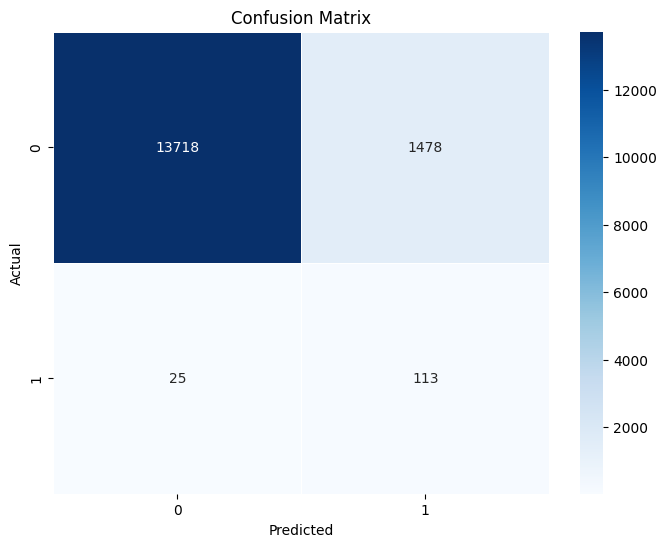

In [57]:

#import pyspark.pandas as ps
from pyspark.sql.functions import lit,col
import pandas as pd
from sklearn.preprocessing import StandardScaler
from xgboost.spark import SparkXGBClassifier
#from boruta import BorutaPy
#from fredapi import Fred
from sklearn.linear_model import Lasso
from sklearn.model_selection import TimeSeriesSplit
import csv
from pyspark.sql import functions as F
from functools import reduce
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import  BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from CreateDataset import get_full_seqs, get_seq_means
from hyperopt import fmin, tpe, hp
from hyperopt.early_stop import no_progress_loss
from pyspark.mllib.evaluation import MulticlassMetrics
import csv
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import chain
import math
from pyspark.ml.classification import FMClassifier
from hyperopt import SparkTrials, Trials

def t_t_split(df):
    split_date = "2019-01-01"

    # Step 3: Filter DataFrame to create train and test sets
    train_df = df.filter(col("end_date") < split_date)
    test_df = df.filter(col("end_date") >= split_date)
    train_label_1_count = train_df.filter(col("label") == 1).count()
    test_label_1_count = test_df.filter(col("label") == 1).count()
    
    # Printing the counts
    print("Length of train/test: ", train_df.count()/(train_df.count() + test_df.count()))
    print("Train DataFrame - Number of rows where label=1:", train_label_1_count)
    print("Test DataFrame - Number of rows where label=1:", test_label_1_count)
    
    return train_df, test_df
    
    
def model_training(df, classifier):
    
    print("Number of records: ", df.count())
    
    features = [c for c in df.columns if c!='fsym_id' and c!='end_date' and c!='label']
    
    train_df, test_df = t_t_split(df)
    
        
    def compute_weights(train_df):
        y_collect = train_df.select("label").groupBy("label").count().collect()
        unique_y = [x["label"] for x in y_collect]
        total_y = sum([x["count"] for x in y_collect])
        unique_y_count = len(y_collect)
        bin_count = [x["count"] for x in y_collect]

        class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
        print(class_weights_spark)
        mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])
        train_df = train_df.withColumn("weight", mapping_expr.getItem(F.col("label")))
        return train_df
    
    def mcc(predictions):
        tp= predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()
       # True Negatives
        tn= predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()
       # False Positives
        fp= predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()
       # False Negatives
        fn= predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()
        if ((tp + fp) * (tp + fn) * (fp + tn) * (tn + fn))==0:
            return 0
        MCC = (tp * tn - fp * fn) / math.sqrt((tp + fp) * (tp + fn) * (fp + tn) * (tn + fn))
        return MCC

        
    train_df = compute_weights(train_df)
    
    vector_assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
    train_df = vector_assembler.transform(train_df)
    test_df = vector_assembler.transform(test_df)

    if classifier == 'LogisticRegression':
        param_space = {
            'regParam': hp.uniform('regParam', 0.01, 1.0),
            'elasticNetParam': hp.uniform('elasticNetParam', 0.0, 1.0)
        }
        classifier_instance = LogisticRegression(featuresCol="features_vector", labelCol="label", weightCol='weight')
    elif classifier == 'RandomForest':
        param_space = {
            'maxBins': hp.quniform('maxBins', 16, 100, 1),
            'maxDepth': hp.quniform('maxDepth', 3, 30, 1),
            'minInstancesPerNode': hp.quniform('minInstancesPerNode', 1, 10, 1),
            'minInfoGain': hp.uniform('minInfoGain', 0.0, 1.0)
        }
        classifier_instance = RandomForestClassifier(featuresCol='features_vector', labelCol='label', weightCol='weight')
    elif classifier == 'GBT':
        param_space = {
            'maxDepth' : hp.quniform("maxDepth", 3, 30, 1),
            'maxBins': hp.quniform('maxBins', 16, 100, 1),
            'minInstancesPerNode': hp.quniform('minInstancesPerNode', 1, 10, 1),
            'minInfoGain': hp.uniform('minInfoGain', 0.0, 1.0)
            
        }
        classifier_instance = GBTClassifier(featuresCol='features_vector', labelCol='label', weightCol='weight')
        
    elif classifier == 'MLP':
        param_space = {
            'layers': hp.choice('layers', [ [len(features), len(features)//2, 2]]),
            'blockSize': hp.choice('blockSize', [128]),
            'stepSize': hp.uniform('stepSize', 0.03, 0.3)
        }
        classifier_instance = MultilayerPerceptronClassifier(layers=[len(features), len(features)//2, 2], seed=123, featuresCol='features_vector', labelCol='label')
        curr_model = classifier_instance.fit(train_df)
        predictions = curr_model.transform(test_df)
        val_metric = mcc(predictions)
        print(val_metric)
        
        
    elif classifier == 'XGB':
        param_space = {
            'eta': hp.uniform('eta', 0.01, 0.3),
            'max_depth': hp.quniform('max_depth', 3, 10, 1),
            'subsample': hp.uniform('subsample', 0.5, 1),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
            
        }
        classifier_instance =SparkXGBClassifier(features_col='features_vector', label_col='label', weight_col='weight', num_workers=2)
        
    elif classifier == 'FactorizationMachines':
        param_space = {
            'stepSize': hp.uniform('stepSize', 0.01, 1.0),
            'maxIter': hp.quniform('maxIter', 1, 100, 1),
            'regParam': hp.uniform('regParam', 0.01, 1.0),
            'factorSize': hp.quniform('factorSize', 4, 64, 1)
        }
        classifier_instance = FMClassifier(featuresCol='features_vector', labelCol='label')

    else:
        raise ValueError("Unsupported classifier")

    

    def cross_val_train(params):
        classifier_instance.setParams(**params)
        curr_model = classifier_instance.fit(train_df)
        predictions = curr_model.transform(test_df)
        val_metric = mcc(predictions)
        return curr_model, val_metric

    
    def objective(params):
        model, metric = cross_val_train(params)
        return -metric

    # Find the best hyperparameters
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=100, early_stop_fn=no_progress_loss(10), trials = Trials())
    print("Best hyperparameters: ", best_params)

    # Train the model with the best hyperparameters
    best_model, final_metric = cross_val_train(best_params)
            
    
    predictions = best_model.transform(test_df)
    true = predictions.select('label').toPandas()
    preds = predictions.select('prediction').toPandas()
    print(classification_report(true, preds))
    
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    return best_model, train_df, test_df
    
model, train_df, test_df = model_training(spark_df, 'GBT')

In [ ]:
new_df[new_df['label']==1].head()

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from hyperopt import fmin, tpe, hp
from sklearn import tree

import shap
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from collections import Counter
from hyperopt.early_stop import no_progress_loss
from functools import reduce
from sklearn.metrics import matthews_corrcoef
import numpy as np

def feature_importances(model, features, model_name):
    feature_importances = model.feature_importances_

    sorted_idx = np.argsort(feature_importances)[::-1]  # Sorting in descending order
    top_features = sorted_idx[:20]  # Selecting top 20 features
    top_feature_importances = feature_importances[top_features]
    top_sorted_features = [features[i] for i in top_features]

    plt.figure(figsize=(12, 8))
    plt.bar(range(len(top_features)), top_feature_importances, align="center")
    plt.xticks(range(len(top_features)), top_sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title(f"All Feature Importances for {model_name}")
    plt.tight_layout()
    plt.savefig(f'results_if2/{model_name}_all_feature_importances.png')
    plt.show()

    return top_sorted_features

def model_testing(df, classifier):
    seed = 42
    df = df.set_index('end_date')
    df = df.sort_index()
    exclude_columns = ['fsym_id', 'label']
    X_train = df.drop(exclude_columns, axis=1)
    y_train = df['label']
    
    tscv = TimeSeriesSplit(n_splits=3)
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(enumerate(class_weights))
    print(class_weight_dict)
    
    if classifier == 'LogisticRegression':
        param_space = {
            'C': hp.uniform('C', 0.01, 1.0) }
        classifier_instance = LogisticRegression(class_weight = class_weight_dict, solver='sag', random_state=seed) #stochastic average gradient
        scaler = StandardScaler()
        feats = X_train.columns
        X_train[feats] = scaler.fit_transform(X_train[feats])
        # X_test[feats] = scaler.transform(X_test[feats])
        
    elif classifier == 'RandomForest':
        param_space = { 
            'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
            'max_depth': hp.quniform('max_depth', 5, 1200, 1),
            'max_features': hp.choice('max_features', [ 'sqrt','log2', None]),
            'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
            'min_samples_split' : hp.uniform ('min_samples_split', 0, 1)
        }
        classifier_instance = RandomForestClassifier(class_weight = class_weight_dict, random_state=seed)
    elif classifier == 'XGB':
        param_space = { 'n_estimators':hp.quniform('n_estimators',100,500,1),
                        'max_depth':hp.quniform('max_depth',5,1200,1),
                       'eta': hp.quniform('eta', 0.025, 1, 0.025),
                       'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
                        'gamma': hp.quniform('gamma', 0.5, 3, 0.05),
                        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05)
                      }
        counter = Counter(y_train)
        # estimate scale_pos_weight value
        estimate = counter[0] / counter[1]
        print('Estimate: %.3f' % estimate)
        
        classifier_instance = xgb.XGBClassifier(seed=seed, scale_pos_weight= estimate)
    else:
        raise ValueError("Unsupported classifier")
    
    def set_params(classifier, params):
        if classifier == 'RandomForest':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'GBT':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            params['min_samples_leaf'] = int(params['min_samples_leaf'])
            params['min_samples_split'] = int(params['min_samples_split'])
            return params
        elif classifier == 'XGB':
            params['max_depth'] = int(params['max_depth'])
            params['n_estimators'] = int(params['n_estimators'])
            # params['min_samples_leaf'] = int(params['min_samples_leaf'])
            # params['min_samples_split'] = int(params['min_samples_split'])
            return params
        
        else:
            return params
    
    obj_scores = []
        
    def objective(params):
        params = set_params(classifier, params)
        classifier_instance.set_params(**params)
        # classifier_instance.fit(X_train, y_train)
        scores = cross_val_score(classifier_instance, X_train, y_train, cv=tscv, scoring='matthews_corrcoef')
        # y_pred = classifier_instance.predict(X_test)
        # recall = recall_score(y_test, y_pred)
        # score = matthews_corrcoef(y_test, y_pred)
        obj_scores.append(scores.mean())
        return -scores.mean()
        
        
#         scores = cross_val_score(classifier_instance, X_train, y_train, cv=3, scoring='matthews_corrcoef')
#         score = -scores.mean()
#         losses.append(score)
#         return score

    def report_average(*args):
        report_list = list()
        for report in args:
            splited = [' '.join(x.split()) for x in report.split('\n\n')]
            header = [x for x in splited[0].split(' ')]
            data = np.array(splited[1].split(' ')).reshape(-1, len(header) + 1)
            data = np.delete(data, 0, 1).astype(float)
            rest = splited[2].split(' ')
            accuarcy =np.array([0, 0, rest[1], rest[2]]).astype(float).reshape(-1, len(header))
            macro_avg = np.array([rest[5:9]]).astype(float).reshape(-1, len(header))
            weighted_avg = np.array([rest[11:]]).astype(float).reshape(-1, len(header))
            #avg_total = np.array([x for x in avg]).astype(float).reshape(-1, len(header))
            df = pd.DataFrame(np.concatenate((data, accuarcy,macro_avg,weighted_avg)), columns=header)
            report_list.append(df)
        res = reduce(lambda x, y: x.add(y, fill_value=0), report_list) / len(report_list)
        res.to_csv(f'when_{classifier}_results.csv')
        return res.rename(index={res.index[-3]: 'accuracy',res.index[-2]: 'macro_avg',res.index[-1]: 'weighted_avg'})
    
    
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=100, early_stop_fn=no_progress_loss(5))
    
#     plt.plot(np.arange(len(l)), losses)
#     plt.xlabel('Iteration')
#     plt.ylabel('Loss')
#     plt.title('Loss during Hyperopt Optimization')
#     plt.show()
    
    best_params = set_params(classifier, best_params)
    classifier_instance.set_params(**best_params)
    
    classifier_instance.fit(X_train, y_train)
    return classifier_instance, X_train.columns.tolist()
    # preds = classifier_instance.predict(X_test)
    
#     final_report = classification_report(y_test, preds)
#     print(final_report)
#     mcc = matthews_corrcoef(y_test, preds)
    
#     filename = f'results_if2/report_{classifier}_if_pandas'
#     existing_mcc = None
#     try:
#         with open(filename, 'r') as f:
#             lines = f.readlines()
#             for line in lines:
#                 if line.startswith('MCC:'):
#                     existing_mcc = float(line.split(':')[1])
#                     break
#     except FileNotFoundError:
#         pass

#     if existing_mcc is None or mcc > existing_mcc:
#         with open(filename, 'w') as f:
#             f.write(final_report)
#             f.write('\nMCC: ' + str(matthews_corrcoef(y_test, preds)))
#             f.write('\nHyperparams: ' + str(best_params))

#     test_df2 = test_df.copy()
#     test_df2['preds'] = preds
    
#     return classifier_instance, X_train.columns.tolist(), X_train, X_test, test_df2



model, feats = model_testing(df_with_industry, 'XGB')

{0: 0.5035514906758523, 1: 70.89297658862876}
Estimate: 140.786
  5%|▌         | 5/100 [01:17<24:39, 15.57s/trial, best loss: -0.132613230698468]


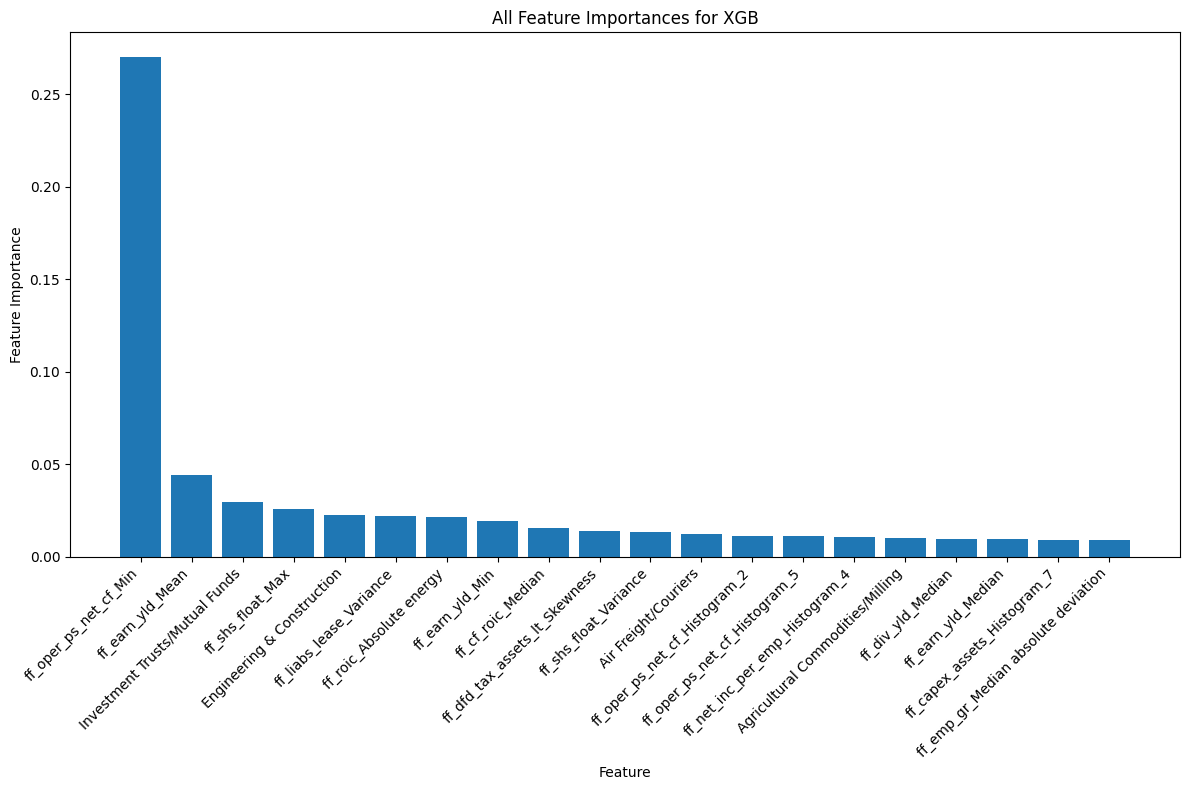

In [62]:
import matplotlib.pyplot as plt
top_feats = feature_importances(model,feats, 'XGB')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


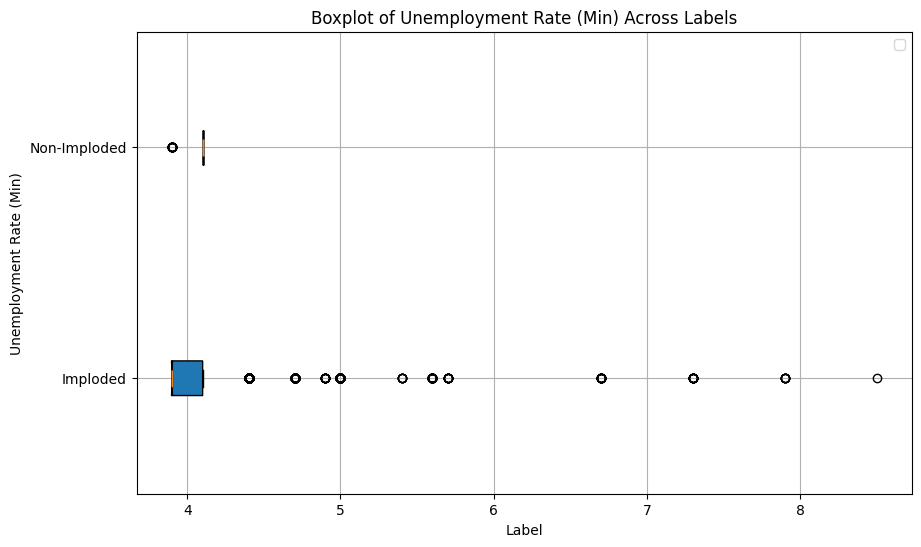

In [137]:
import seaborn as sns

# Assuming 'df' is your DataFrame and 'column_name' is the name of the column you want to plot
plt.figure(figsize=(10, 6))

plt.boxplot([df[df['label'] == 0]['Unemployment_Rate_Min'], 
                df[df['label'] == 1]['Unemployment_Rate_Min']],
                labels=['Imploded', 'Non-Imploded'], vert=False, notch=True, patch_artist=True)

plt.xlabel('Label')  # Label for x-axis
plt.ylabel('Unemployment Rate (Min)')  # Label for y-axis
plt.title('Boxplot of Unemployment Rate (Min) Across Labels')  # Title of the plot
plt.grid(True)  # Show grid
plt.legend()  
# plt.savefig('results_if/unemployment_box_plot_if.png')# Show legend
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


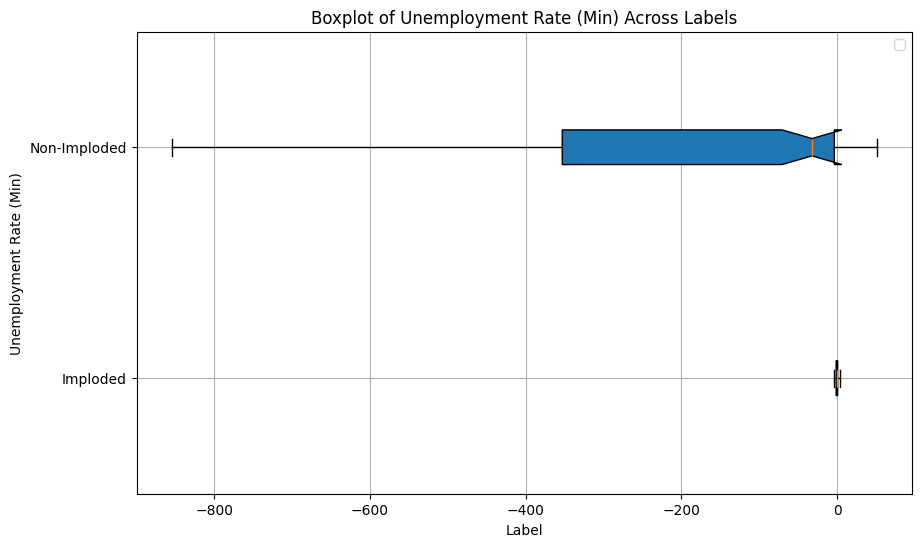

In [138]:
import seaborn as sns

# Assuming 'df' is your DataFrame and 'column_name' is the name of the column you want to plot
plt.figure(figsize=(10, 6))


plt.boxplot([df[df['label'] == 0]['ff_oper_ps_net_cf_Min'], 
                df[df['label'] == 1]['ff_oper_ps_net_cf_Min']],
                labels=['Imploded', 'Non-Imploded'], vert=False, notch=True, patch_artist=True, showfliers=False)

plt.xlabel('Label')  # Label for x-axis
plt.ylabel('Unemployment Rate (Min)')  # Label for y-axis
plt.title('Boxplot of Unemployment Rate (Min) Across Labels')  # Title of the plot
plt.grid(True)  # Show grid
plt.legend()  
# plt.savefig('results_if/unemployment_box_plot_if.png')# Show legend
plt.show()


In [112]:
from hyperopt import hp, fmin, tpe, Trials
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Define the search space for hyperparameters

def hyperopt_nn(train_df):
    exclude_columns = ['fsym_id', 'label']
    feats = train_df.drop(exclude_columns, axis=1).columns.tolist()
    X_train = train_df.drop(exclude_columns, axis=1)
    y_train = train_df['label']
    # X_val = test_df.drop(exclude_columns, axis=1)
    # y_val = test_df['label']
    
    space = {
        'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
        'batch_size': hp.choice('batch_size', [1024, 2048, 4096]),
        'num_layers': hp.choice('num_layers', [2, 3, 4, 5, 6]),
        'num_neurons': hp.choice('num_neurons', [128, 256, 512, 1024, 2048, 4096]),
        'dropout_rate': hp.uniform('dropout_rate', 0, 0.5),
        'class_weight_0': hp.uniform('class_weight_0', 0.1, 5),  
        'class_weight_1': hp.uniform('class_weight_1', 0.1, 100) 
    }

    scaler=StandardScaler()
    X_train = scaler.fit_transform(X_train)
    # X_val = scaler.transform(X_val)
    
    X_train_df = pd.DataFrame(X_train, columns=feats)
    # X_val_df = pd.DataFrame(X_val, columns=feats)
    # class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    # class_weight_dict = dict(enumerate(class_weights))
    # print(class_weight_dict)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    tscv = TimeSeriesSplit(n_splits=2)
    
    def time_series_cross_validation(X, y, params):
        # Define the number of splits

        metrics = []  # Store metrics for each fold
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Flatten(input_shape=(X.shape[1],)))

        for _ in range(params['num_layers']):
            model.add(tf.keras.layers.Dense(params['num_neurons'], activation='relu'))
            model.add(tf.keras.layers.Dropout(params['dropout_rate']))

        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

        for train_index, val_index in tscv.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

              # Define your model creation function

            optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
            model.compile(optimizer=optimizer, loss='binary_crossentropy')

            class_weight_dict = {0: params['class_weight_0'], 1: params['class_weight_1']}
            hist = model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=10, class_weight=class_weight_dict, callbacks=[early_stopping], verbose=0)

            preds = model.predict(X_val, batch_size=params['batch_size'], verbose=0)
            preds = np.where(preds >= 0.5, 1, 0)

            metric = matthews_corrcoef(y_val, preds)
            metrics.append(metric)

        return model, sum(metrics)/len(metrics)

#     def train_with_params(params):
#         model = tf.keras.Sequential()
#         model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)))

#         for _ in range(params['num_layers']):
#             model.add(tf.keras.layers.Dense(params['num_neurons'], activation='relu'))
#             model.add(tf.keras.layers.Dropout(params['dropout_rate']))

#         model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

#         optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
#         model.compile(optimizer=optimizer, loss='binary_crossentropy')

#         class_weight_dict = {0: params['class_weight_0'], 1: params['class_weight_1']}
#         hist = model.fit(X_train, y_train, batch_size=params['batch_size'], epochs=10, class_weight = class_weight_dict, callbacks = [early_stopping], verbose=0)
#         preds = model.predict(X_val, batch_size=params['batch_size'], verbose=0 )
#         for i in range(len(preds)):
#             preds[i] = 1 if preds[i] >=0.5 else 0
            
#         metric = matthews_corrcoef(y_val, preds)
#         return model, metric
    
    
    def objective(params):
        model, metric = time_series_cross_validation(X_train, y_train, params)
        return -metric



    # Run hyperparameter optimization
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, early_stop_fn=no_progress_loss(10))
    
    activation_map = {0: 'relu', 1: 'sigmoid'}
    best_hyperparams = {
        'learning_rate': best['learning_rate'],
        'batch_size': [1024, 2048, 4096, 8192][best['batch_size']],
        'num_layers': [2, 3, 4, 5, 6][best['num_layers']],
        'num_neurons': [128, 256, 512, 1024, 2048][best['num_neurons']],
        'dropout_rate': best['dropout_rate'],
        'class_weight_0': best['class_weight_0'],
        'class_weight_1': best['class_weight_1']
    }

    print("Best hyperparameters:", best_hyperparams)
    best_model, best_metric = train_with_params(best_hyperparams)
    print(f'Best metric: {best_metric}')
    preds = best_model.predict(X_val, batch_size = best_hyperparams['batch_size'])
    print(preds)
    for i in range(len(preds)):
        preds[i] = 1 if preds[i] >= 0.5 else 0
    final_report = classification_report(y_val, preds)
    mcc = matthews_corrcoef(y_val, preds)
    filename = f'results_if2/report_mlp_when'
    existing_mcc = None
    try:
        with open(filename, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.startswith('MCC:'):
                    existing_mcc = float(line.split(':')[1])
                    break
    except FileNotFoundError:
        pass

    # Overwriting file only if new MCC is larger
    if existing_mcc is None or mcc > existing_mcc:
        with open(filename, 'w') as f:
            f.write(final_report)
            f.write('\nMCC: ' + str(mcc))
            f.write('\nHyperparams: ' + str(best_hyperparams))
            
    return best_model, X_train_df, X_val_df
    
model, X_train, X_test = hyperopt_nn(df)


 14%|█▍        | 7/50 [18:06<1:51:14, 155.22s/trial, best loss: -0.07781323947018147]


KeyboardInterrupt: 

In [12]:
import shap


def shapley(model, train, test, model_name, plot_type):
    # train = train.toPandas()
    # test=test.toPandas()
    # exclude_columns = ['fsym_id',  'label']
    # X_train = train.drop(exclude_columns, axis=1)
    # X_test = test.drop(exclude_columns, axis=1)
    explainer = shap.Explainer(model,train)
    shap_values = explainer(test)
    shap.initjs()
    # print(shap_values.shape)
    # shap.plots.beeswarm(shap_values)
    # shap.summary_plot(shap_values,test,show=False)
    if plot_type == 'bar':
        shap.plots.bar(shap_values, max_display=20, show=False)
    elif plot_type == 'beeswarm':
        shap.plots.beeswarm(shap_values, max_display=20, show=False)
        
    plt.tight_layout()
    plt.savefig(f'results_if2/{model_name}_shap_{plot_type}.png')
    
    
# shapley(model, train_df, test_df, model_name='rf')
    
# shapley(model, X_train, X_test, 'XGB', 'beeswarm')

In [38]:
def shapley(model, train, test, feature_names, model_name):
    train_df = pd.DataFrame(train, columns=feature_names)  # Convert train to DataFrame if it's not already
    explainer = shap.DeepExplainer(model, train_df.sample(100))  # Sample from train_df
    shap_values = explainer.shap_values(test)
    shap.initjs()
    shap.summary_plot(shap_values, test, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig(f'results_if/{model_name}_shap.png')

# feats = train_df.drop(['fsym_id', 'label'], axis=1).columns.tolist()
# shapley(model, X_train, X_test, feats, model_name='MLP')


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras import layers



def plot_model_performance(mdl, loss, metric):
    x = pd.DataFrame(mdl.history).reset_index()
    x = pd.melt(x, id_vars='index')
    x['validation'] = (x['variable'].str[:4] == 'val_').replace({True:'validation',False:'training'})
    x['loss'] = (x['variable'].str[-4:] == 'loss').replace({True:loss,False:metric})
    g = sns.FacetGrid(x, col='loss', hue='validation',sharey=False)
    g.map(sns.lineplot, 'index','value')
    g.add_legend()
    return g

def nn_training(df):
    train_df, test_df = t_t_split(df)

    train_df = train_df.toPandas()
    train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows containing NaN values
    train_df.dropna(axis=0, how='any', inplace=True)
    
    test_df = test_df.toPandas()
    train_X = train_df.drop(['fsym_id', 'label'], axis=1).values
    train_y = np.array(train_df['label'])
    test_X = test_df.drop(['fsym_id', 'label'], axis=1).values
    test_y = np.array(test_df['label'])
    print(np.sum(test_y==1))
    print(train_X, train_y)
    
    class_labels = np.unique(train_y)
    class_weights = compute_class_weight('balanced', classes=class_labels, y=train_y.flatten())
    class_weight_dict = dict(zip(class_labels, class_weights))
    print(class_weight_dict)
    

    # Define the neural network model
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(train_X.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),  # Additional Dense layer
        tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
        tf.keras.layers.Dense(16, activation='relu'),  # Another Dense layer
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # model = keras.Sequential()
    # model.add(layers.Dense(16,activation="relu",input_shape=(train_X.shape[1],)))
    # model.add(layers.Dense(8,activation="tanh"))
    # model.add(layers.Dense(1))


    # Compile the model
    loss_fn = keras.losses.BinaryCrossentropy()
    optimizer = keras.optimizers.Adam(
        learning_rate=0.001
    )

    
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    # Train the model
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    fit_model = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_split=0.1, class_weight = class_weight_dict)
    plot_model_performance(fit_model, 'bin_cross_entropy','accuracy')

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(test_X, test_y)
    print(f'Test accuracy: {test_acc}')

    # Make predictions on new data
    predictions = model.predict(test_X)
    for i in range(len(predictions)):
        predictions[i] = 1 if predictions[i] >= 0.5 else 0
    print(classification_report(predictions, test_y.flatten()))
    
    # pred_df = pd.DataFrame()
    # pred_df['prediction'] = predictions
    # pred_df['label'] = test_y
    # confusion_matrix_pandas(pred_df)
    cm = confusion_matrix(test_y, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

nn_training(df)

15
37


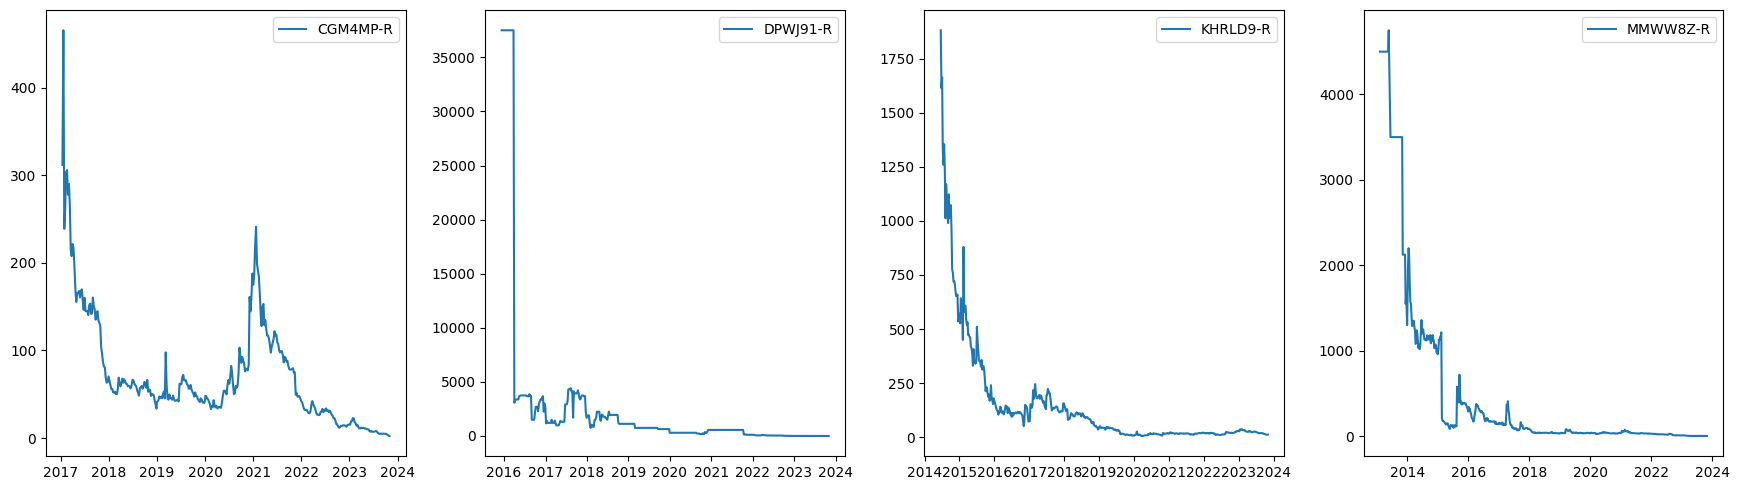

In [130]:
from CreateDataset import get_fund_data
import math

def plotting_stocks_pandas(df):
    imploded_stocks = df[(df['label'] == 0) & (df['preds'] == 1)]
    spark_df = spark.createDataFrame(imploded_stocks['fsym_id'].to_frame())
    imp_prices = get_fund_data(spark_df)
    
    adj_pd = imp_prices.toPandas()
    adj_pd['date'] = pd.to_datetime(adj_pd['date'])
    list_to_plot = sorted(adj_pd['fsym_id'].unique().tolist())
    
    columns = 8
    num_rows = math.ceil(len(list_to_plot) / columns)
    fig, axs = plt.subplots(nrows=num_rows, ncols=columns, figsize=(35, 5*num_rows))
    axs = axs.flatten()
    
    i = 0
    for t in list_to_plot:
        temp_df = adj_pd[adj_pd['fsym_id']==t]
        axs[i].plot(temp_df['date'], temp_df['adj_price'], label=t)

        axs[i].legend()
        #axs[i].text(0.5, -0.1, f'Volatility: {vol:.2f}', ha='center', transform=axs[i].transAxes)
        i+=1
        
    for i in range(len(list_to_plot), num_rows * columns):
        fig.delaxes(axs.flatten()[i])
    
        
    plt.tight_layout()
    plt.savefig('results_if2/incorrect_implosions_detected_by_model_if.png')
    
print(len(full_test_df[full_test_df['preds']==1]))
print(len(full_test_df[full_test_df['label']==1]))
plotting_stocks_pandas(full_test_df) 

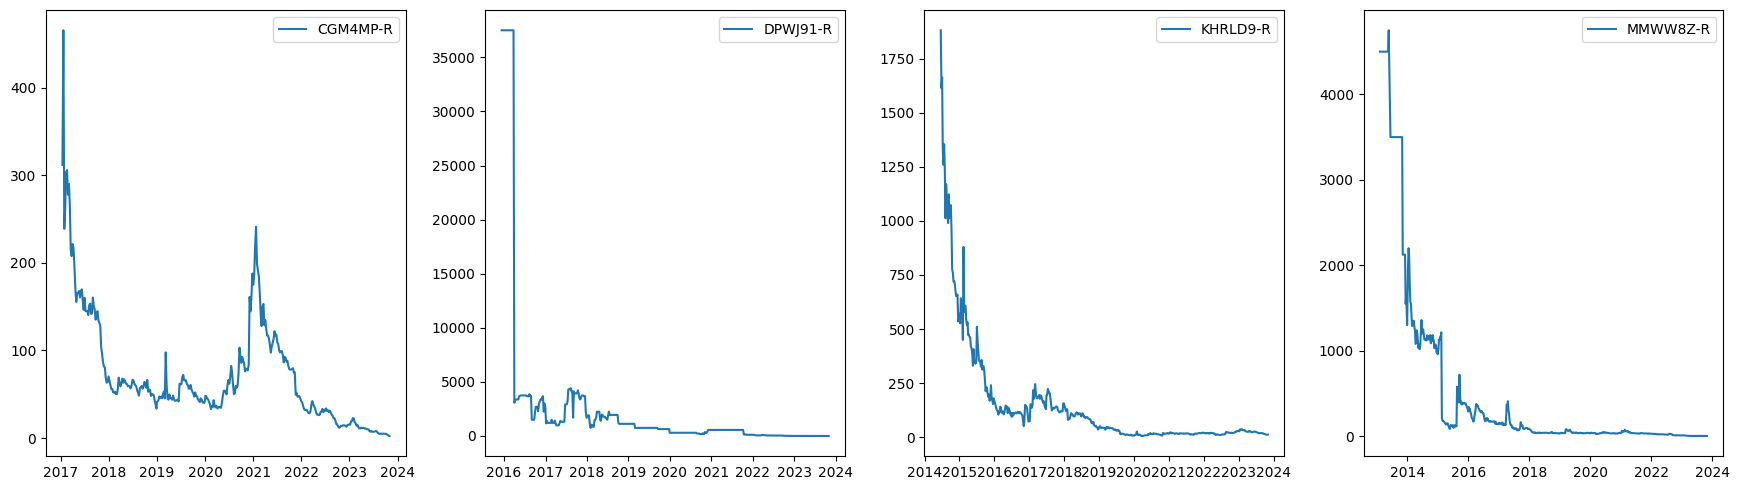### Investigating metrics that changed the most before and after implosions

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv


def pct_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, t.Implosion_Start_Date, b.date, {big_string}
                FROM temp_table t
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) = YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) = YEAR(t.Implosion_Start_Date)-1
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    #print(df1.show())
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id','Implosion_Start_Date','date'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]



    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)

    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)

    print("Largest averages of differences between previous year and implosion year: ",feats)
    return feats.index.tolist()
    
def avg_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, {big_string}
                FROM temp_table t  
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) > YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) < YEAR(t.Implosion_Start_Date)
                GROUP BY t.fsym_id
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]


    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)
    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)
    print("Largest averages of differences in average before and after implosion date: ", feats)
#     for feature in feats.index:
#         before_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] < df1['Implosion_Start_Date'])].index)]
#         after_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] > df1['Implosion_Start_Date'])].index)]
        
#         _, p_value = ttest_ind(before_implosion, after_implosion)
        
#         print(f"T-test p-value for {feature}: {p_value}")
    return feats.index.tolist()

def t_test():
    pass


def get_metric_changes(filename, table):
    df = pd.read_csv(filename, index_col=False)
    df = df[df['Implosion_Start_Date'].notnull()]
    df['Implosion_Start_Date'] = pd.to_datetime(df['Implosion_Start_Date']).dt.date
    df['Implosion_End_Date'] = pd.to_datetime(df['Implosion_End_Date']).dt.date
    cols = get_not_null_cols(df, table)
    result_string = ', '.join('(a.' + item + '-b.' + item +')/b.'+item + ' AS ' + item for item in cols)
    feats1 = pct_change_df(df, result_string, table) #change 1 year before
    print("Features with greatest percentage change with year before implosion: ", feats1)
    
    result_string2 = ', '.join('(MEAN(a.' + item + ')-MEAN(b.' + item +'))/MEAN(b.'+item + ') AS ' + item for item in cols)
    feats2 = avg_change_df(df, result_string2, table)
    print("Features with greatest percentage change in mean before and after implosion", feats2)
    
    write_features_file( list(set(feats1+feats2)) )


get_metric_changes('imploded_stocks_price.csv', 'FF_ADVANCED_DER_AF')


### Correlations with Market Value Returns

In [ ]:
import csv
from CreateDataset import get_feature_col_names, get_fund_data


def corr_query(implosion_df, col_string, table): 
    df = get_fund_data(implosion_df)
    df=df.withColumn('year', F.year('date'))
    window_spec = Window.partitionBy('fsym_id', 'year').orderBy(col('date').desc())

    df = df.withColumn('row_num', F.row_number().over(window_spec))

    df = df.filter(col('row_num') == 1).orderBy('date') #should we compare correlations with market val?
    #should we do quarterly?
    
    df.createOrReplaceTempView("temp_table")
    query1 = f"""
                SELECT t.fsym_id, t.adj_price, t.Market_Value, t.date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.date
            """
 
    q_df = spark.sql(query1)
    #q_df.show()
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    
    q_df = q_df.withColumn("return_market_val", (F.col('Market_Value') - F.lag('Market_Value').over(window_spec)) / F.lag('Market_Value').over(window_spec))
    q_df = q_df.withColumn("return", (F.col('adj_price') - F.lag('adj_price').over(window_spec)) / F.lag('adj_price').over(window_spec))
    
    return_columns = [c[2:] for c in col_string.split(", ")]
    mean_corrs = []
    corr_vals = []
    #I THINK U NEED TO GROUP BY DATE AND THEN CALCULATE CORRELATIONS

    for column in return_columns:
        return_col_name = f"return_{column}"
        corr_col_name = f"corr_with_{column}"
        q_df = q_df.withColumn(return_col_name, (F.col(column) - F.lag(column).over(window_spec)) / F.lag(column).over(window_spec))
        q_df = q_df.withColumn(column, F.corr(return_col_name, 'return_market_val').over(window_spec)) #calculating correlations with market value return
        q_df = q_df.drop(*[return_col_name])
    q_df = q_df.drop(*['return_market_val', 'return'])
    q_df = q_df.select(q_df.columns[4:])
    mean_corrs = q_df.agg(*[F.mean(F.abs(F.col(column))).alias(column) for column in q_df.columns])
    # mean_corrs.show()
    
    return mean_corrs.toPandas()

def corr_analysis(table):
    imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imp_df_price = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
    cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    result_string = ', '.join('a.' + item for item in cols)
    mean_corrs_df = corr_query(spark.createDataFrame(imp_df_price), result_string, 'FF_ADVANCED_DER_AF')
    mean_corrs = mean_corrs_df.to_dict(orient='records')
    sorted_corrs = dict(sorted(mean_corrs[0].items(), key=lambda item: item[1], reverse=True))
    top_records = list(sorted_corrs.items())[:5]
    top_10 = []
    for r in top_records:
        top_10.append(r[0])
    print(top_10)
    current_feature_list = get_feature_col_names()
    new_feature_list = list(set(current_feature_list + top_10))
    
    write_features_file(new_feature_list)
    
    
corr_analysis('FF_Advanced_Der_AF')

### Adding the Extra Features From Literature

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price['Implosion_Start_Date'] = pd.to_datetime(imp_df_price['Implosion_Start_Date'])
imp_df_price['Implosion_End_Date'] = pd.to_datetime(imp_df_price['Implosion_End_Date'])
available_feats = get_not_null_cols(imp_df_price)
extra_feats = ['ff_capex_assets', 'ff_gross_cf_debt', 'ff_mkt_val_gr']

current_feats = get_feature_col_names()
final_feats = list(set(current_feats + extra_feats))
write_features_file(final_feats)

### Boruta

In [ ]:
def get_df(all_feats=False, imploded_only=False):
    df = get_tabular_dataset(all_feats=all_feats, imploded_only=imploded_only)
    df = forward_fill(df)
    print("Number of rows: ", df.count())
    print("Number of positives: ", df.filter(F.col('label')==1).count())
    df=df.fillna(0.0)
    print("Number of rows after dropping nulls: ", df.count())
    print("Number of positives after dropping nulls: ", df.filter(F.col('label')==1).count())
    return df


def forward_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    for c in feature_cols:
        df = df.withColumn(
            c, F.last(c, ignorenulls=True).over(window_spec)
        )
    return df.orderBy('fsym_id','date')

df = get_df()


In [ ]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
gbt_feats = boruta_fs(df, 'gbt')

In [ ]:
# current_features = get_feature_col_names()
# for f in boruta_features:
#     if f in current_features:
#         print(f)
# final_features = list(set(boruta_features + current_features))
# write_features_file(final_features) #in the feature selection pipeline, 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def correlation_matrix(df):
    df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    # plt.savefig('corr_matrix.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                
# correlation_matrix(train_df)

In [ ]:
df = df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
                        'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot')
feats = df.columns[2:-1]
# write_features_file(feats)
feats

### Extra

In [ ]:
def start_dates(imp_df_price):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    #cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    #result_string = ', '.join('a.' + item for item in cols)
    
    window_spec = Window.partitionBy('fsym_id').orderBy(col('p_date'))

    price_data = price_data.withColumn('row_num', F.row_number().over(window_spec))
    price_data.show()

    price_data = price_data.filter(col('row_num') == 1).orderBy(col('p_date').desc())
    price_data.show()
    
    start_dates = price_data.groupBy('year').count().orderBy('year')
    years = [row['year'] for row in start_dates.collect()]
    counts = [row['count'] for row in start_dates.collect()]
    plt.bar(years, counts)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Start Dates Count per Year')
    plt.show()
    #start_dates.show(25)
    
def null_vals(imp_df_price, table):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    cols = get_not_null_cols(imp_df_price, table)
    col_string = ', '.join('a.' + item for item in cols)
    price_data.createOrReplaceTempView('temp_table')
    null_counts = []
    query1 = f"""
                SELECT t.fsym_id, t.split_adj_price, t.Market_Value, t.p_date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.p_date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.p_date
            """
    full_df = spark.sql(query1)
    for column in cols:
        null_count = full_df.select(column).filter(col(column).isNull()).count()
        null_counts.append((column, null_count))
    null_counts_df = pd.DataFrame(null_counts, columns=['Column', 'Null Count'])
    plt.figure(figsize=(10, 6))
    plt.bar(null_counts_df['Column'], null_counts_df['Null Count'])
    plt.xlabel('Column')
    plt.ylabel('Null Count')
    plt.title('Null Counts for Each Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    # null_counts = price_data.groupBy('year').agg(F.sum(col('p_price').isNull().cast('int')).alias('null_count'))
    # null_counts.show()
    
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price_imploded = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
start_dates(imp_df_price)
start_dates(imp_df_price_imploded)

#null_vals(imp_df_price, 'FF_ADVANCED_DER_AF')

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_test = imp_df_price[imp_df_price['fsym_id']=='H7CTYF-R']
df = get_fund_data(spark.createDataFrame(imp_df_test))
df.show(1000)
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))

In [ ]:
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))
print(len(imp_df_price))

In [ ]:
def get_cols():
    df_metrics = ps.DataFrame(spark.sql("SELECT * FROM FF_BASIC_AF LIMIT 10")) #get all the metrics
    cols = []
    for c in df_metrics.columns:
        if df_metrics[c].dtype=='float64':#get all the metrics we can calculate correlations with
            cols.append(c)
    return cols

#%change average of each feature plotted for pharmacy industry
def industry_analysis():
    stock_df = get_all_stocks_df()
    #stock_df = pd.read_csv('imploded_stocks.csv')
    #stock_df = spark.createDataFrame(stock_df)
    cols = ['ff_gross_inc', 'ff_sales', 'FF_OPER_EXP_TOT', 'FF_CASH_ST']
    col_string = ', '.join('a.' + item for item in cols)
    stock_df.createOrReplaceTempView("temp_table")
    q = f"""SELECT e.factset_industry_desc, t.ticker_region, a.date, {col_string} FROM temp_table t
    LEFT JOIN FF_BASIC_AF a ON a.fsym_id = t.fsym_id
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    WHERE a.date >= "2009-01-01" AND e.factset_industry_desc="Regional Banks"
    ORDER BY t.ticker_region,a.date"""
    ind_df = spark.sql(q)
    #print(ind_df.show(10))
    ind_df =ind_df.toPandas()
    ind_df['date'] = pd.to_datetime(ind_df['date'])
    new_cols = []
    for column in cols:
        ind_df[f'{column}_percentage_change'] = ind_df.groupby('ticker_region')[column].pct_change() * 100
        ind_df[f'{column}_percentage_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
        ind_df.drop(column, axis=1, inplace=True)
        new_cols.append(f'{column}_percentage_change')
    ind_df['year'] = ind_df['date'].dt.year
    avg_pct_change = ind_df.groupby(['year'])[new_cols].mean().reset_index()
    print(avg_pct_change.head(20))
    num_rows = (len(new_cols) + 1) // 2  # Adjust the number of rows as needed
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    for i,column in enumerate(new_cols):
        row = i//num_cols
        col = i % num_cols 
        axes[row,col].plot(avg_pct_change['year'], avg_pct_change[column])
        axes[row, col].set_title(f'Avg {column} Percentage Change Over Time')
        axes[row, col].set_xlabel('Year')
        axes[row, col].set_ylabel(f'Avg {column} Percentage Change')
        axes[row, col].grid(True)
    plt.tight_layout()
    plt.show()

#industry_analysis()

In [ ]:

#YOU'VE DONE WORST CHANGES NOW FIND OUT WHICH ONES DECREASE CONSISTENTLY
#ALSO FIGURE OUT MEANS BEFORE PERIOD AND AFTER PERIOD USING QUARTERLY AND COMPARE DIFF
#FINALLY WITH A HUGE LIST USE BORUTA

In [ ]:
def get_not_null_cols(df, table='FF_ADVANCED_DER_AF'):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    query1 = f"""SELECT t.fsym_id, a.*
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id
                ORDER BY t.fsym_id, a.date
            """
    #we get all the available dates per stock, so these null values are only within the timeframe available
    q_df = spark.sql(query1)
    column_types = q_df.dtypes
    null_pcts = []
    for c, dtype in zip(q_df.columns, column_types):
        if dtype[1] == 'double':
            null_count = q_df.filter(F.col(c).isNull()).count()
            null_pcts.append(null_count/q_df.count())


    columns_to_drop = [col_name for col_name, null_pct, dtype in zip(q_df.columns, null_pcts, column_types) if null_pct > 0.2 or dtype[1]!='double']

    q_df = q_df.drop(*columns_to_drop)

    cols = q_df.columns
    print(cols)

    return cols
    
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
df = df.loc[df['Implosion_Start_Date'].notnull()]
get_not_null_cols(df)

In [ ]:
spark.stop()

## spark version of training

In [ ]:
from hyperopt import fmin, tpe, hp
import csv
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import chain
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import matthews_corrcoef



def feature_importances(model, features, name):
    feature_importances = model.featureImportances.toArray()
    

    top_features_idx = np.argsort(feature_importances)[-25:]  # Get the indices of the top 25 features
    sorted_features = [features[i] for i in top_features_idx]


    plt.figure(figsize=(20, 6))
    plt.bar(range(len(sorted_features)), feature_importances[top_features_idx], align="center")
    plt.xticks(range(len(sorted_features)), sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importances")
    plt.savefig(f'{name}_if_feats.png', bbox_inches='tight')
    return sorted_features
    
    
def model_training_spark(train_df, test_df, classifier):
    
    features = train_df.drop('fsym_id', 'label').columns
        
    def compute_weights(train_df):
        y_collect = train_df.select("label").groupBy("label").count().collect()
        unique_y = [x["label"] for x in y_collect]
        total_y = sum([x["count"] for x in y_collect])
        unique_y_count = len(y_collect)
        bin_count = [x["count"] for x in y_collect]

        class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
        print(class_weights_spark)
        mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])
        train_df = train_df.withColumn("weight", mapping_expr.getItem(F.col("label")))
        return train_df
        
    train_df = compute_weights(train_df)
    
    vector_assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
    train_df = vector_assembler.transform(train_df)
    test_df = vector_assembler.transform(test_df)

    if classifier == 'LogisticRegression':
        param_space = {
            'regParam': hp.uniform('regParam', 0.01, 1.0),
            'elasticNetParam': hp.uniform('elasticNetParam', 0.0, 1.0)
        }
        classifier_instance = LogisticRegression(featuresCol="features_vector", labelCol="label", weightCol='weight')
    elif classifier == 'RandomForest':
        param_space = {
            'maxBins': hp.quniform('maxBins', 16, 256, 1),
            'maxDepth': hp.quniform('maxDepth', 20, 30, 1)
        }
        classifier_instance = RandomForestClassifier(featuresCol='features_vector', labelCol='label', weightCol='weight')
    elif classifier == 'GBT':
        param_space = {
            'maxDepth' : hp.quniform("maxDepth", 20, 30, 1),
            'maxBins': hp.quniform('maxBins', 16, 128, 1)
        }
        classifier_instance = GBTClassifier(featuresCol='features_vector', labelCol='label')
    else:
        raise ValueError("Unsupported classifier")
    
    # initial_model = classifier_instance
    # initial_model = initial_model.fit(train_df)
    def mcc(truth, preds):
        truth = truth.toPandas()
        preds = preds.toPandas()
        metric = matthews_corrcoef(truth, preds)
        return metric

    def cross_val_train(params):
        classifier_instance.setParams(**params)
        # evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
        # train, val = train_df.randomSplit([0.9,0.1])
        # curr_model = classifier_instance.fit(train)
        # predictions = curr_model.transform(val)
        # val_metric = evaluator.evaluate(predictions)
        # return curr_model, val_metric
        # paramGrid = ParamGridBuilder().build()
        # crossval = CrossValidator(estimator=classifier_instance,
        #                           estimatorParamMaps=paramGrid,
        #                           evaluator=evaluator,
        #                           numFolds=5, parallelism=12)
        
        cv_model = classifier_instance.fit(train_df)
        predictions = cv_model.transform(test_df)
        val_metric = mcc(predictions.select('label'), predictions.select('prediction'))
        
        return cv_model, val_metric
    
    
    def objective(params):
        model, metric = cross_val_train(params)
        return -metric

    # Find the best hyperparameters
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=50, early_stop_fn=no_progress_loss(10))
    print("Best hyperparameters: ", best_params)

    # Train the model with the best hyperparameters
    best_model, final_metric = cross_val_train(best_params)
            
    
    predictions = best_model.transform(test_df)
    true = predictions.select('label').toPandas()
    preds = predictions.select('prediction').toPandas()
    print(classification_report(true, preds))
    print("MCC: ", matthews_corrcoef(true, preds))
    
    with open(f'if_{classifier}.txt', 'w') as f:
        f.write(classification_report(true, preds))
        f.write(f"\n\nMatthews Correlation Coefficient: {matthews_corrcoef(true, preds)}")
    
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    return best_model, train_df,  predictions


# model, train_df_done, pred_df = model_training_spark(train_df2, test_df2, 'GBT')